# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: D:\ID2223 Scalable Machine Learning\Lab 1\mlfs-book
HopsworksSettings initialized!


In [71]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import importlib
from mlfs.airquality import util
importlib.reload(util)
import os

In [5]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 15, 13, 43, 159751)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [8]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
url = location['aqicn_url']

2025-11-16 15:14:29,467 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:14:29,481 INFO: Initializing external client
2025-11-16 15:14:29,481 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:14:31,228 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286306


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [9]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_rolling",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-16 15:14:42,730 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/517578 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

In [10]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.4154917E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [44]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality_rolling',
    version=1,
)
air_quality_data = air_quality_fg.read()
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.44s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-17 00:00:00+00:00,0.75,0.0,12.181624,325.840240,stockholm
1,2025-11-19 00:00:00+00:00,0.05,1.4,10.483357,15.945477,stockholm
2,2025-11-18 00:00:00+00:00,-0.00,0.0,6.618519,292.380188,stockholm
3,2025-11-20 00:00:00+00:00,-1.35,0.0,8.049845,349.695221,stockholm
4,2025-11-21 00:00:00+00:00,-3.60,0.0,7.653705,318.814148,stockholm
5,2025-11-22 00:00:00+00:00,1.75,0.0,19.296135,216.656204,stockholm
6,2025-11-23 00:00:00+00:00,2.40,0.0,3.758510,106.699326,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [59]:
# make prediction from rolling
days = 7
current_date = air_quality_data['date'].max()
last_date = current_date + datetime.timedelta(-3) # For 3-days rolling window
rolling_data = air_quality_data[(air_quality_data['date'] <= current_date) & ((air_quality_data['date'] > last_date))]
for day in range(days):

    rolling_data_pseu = rolling_data
    last_date = current_date + datetime.timedelta(-3) # For 3-days rolling window
    rolling_data = rolling_data_pseu[(rolling_data_pseu['date'] <= current_date + datetime.timedelta(day)) & (rolling_data_pseu['date'] > last_date + datetime.timedelta(day))]
    predicted_date = current_date + datetime.timedelta(day+1)
    pm25_data_3days = rolling_data['pm25']
    rolling3 = pm25_data_3days.mean()
    rolling3= rolling3.astype('float32')

    last_date = current_date + datetime.timedelta(-2) # For 2-days rolling window
    rolling_data = rolling_data_pseu[(rolling_data_pseu['date'] <= current_date + datetime.timedelta(day)) & (rolling_data_pseu['date'] > last_date + datetime.timedelta(day))]
    predicted_date = current_date + datetime.timedelta(day+1)
    pm25_data_2days = rolling_data['pm25']
    rolling2 = pm25_data_2days.mean()
    rolling2= rolling2.astype('float32')

    last_date = current_date + datetime.timedelta(-1) # For 1-days rolling window
    rolling_data = rolling_data_pseu[(rolling_data_pseu['date'] <= current_date + datetime.timedelta(day)) & (rolling_data_pseu['date'] > last_date + datetime.timedelta(day))]
    predicted_date = current_date + datetime.timedelta(day+1)
    pm25_data_1days = rolling_data['pm25']
    rolling1 = pm25_data_1days.mean()
    rolling1= rolling1.astype('float32')
    
    new_row = {'date': predicted_date, 'pm25': 0, 'country':country,'city':city,'street':street,'url':url,'rolling1':rolling1,'rolling2':rolling2,'rolling3':rolling3}
    batch_data.loc[batch_data['date'] == predicted_date,'rolling1'] = rolling1
    batch_data.loc[batch_data['date'] == predicted_date,'rolling2'] = rolling2
    batch_data.loc[batch_data['date'] == predicted_date,'rolling3'] = rolling3
    batch_data.loc[batch_data['date'] == predicted_date,'predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[batch_data['date'] == predicted_date][['rolling1','rolling2','rolling3','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
    rolling_data = pd.concat([rolling_data, pd.DataFrame([new_row])], ignore_index=True)
    rolling_data.loc[rolling_data['date'] == predicted_date, 'pm25'] = batch_data.loc[batch_data['date'] == predicted_date,'predicted_pm25'].values[0]

batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling1,rolling2,rolling3,predicted_pm25
0,2025-11-17 00:00:00+00:00,0.75,0.0,12.181624,325.840240,stockholm,7.000000,9.500000,10.666667,20.561321
1,2025-11-19 00:00:00+00:00,0.05,1.4,10.483357,15.945477,stockholm,35.573330,28.067326,28.067326,23.177694
2,2025-11-18 00:00:00+00:00,-0.00,0.0,6.618519,292.380188,stockholm,20.561321,13.780661,13.780661,35.573330
3,2025-11-20 00:00:00+00:00,-1.35,0.0,8.049845,349.695221,stockholm,23.177694,29.375511,29.375511,25.922142
4,2025-11-21 00:00:00+00:00,-3.60,0.0,7.653705,318.814148,stockholm,25.922142,24.549919,24.549919,40.608109
5,2025-11-22 00:00:00+00:00,1.75,0.0,19.296135,216.656204,stockholm,40.608109,33.265125,33.265125,34.302017
6,2025-11-23 00:00:00+00:00,2.40,0.0,3.758510,106.699326,stockholm,34.302017,37.455063,37.455063,39.003830


In [60]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         7 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          7 non-null      float32                
 2   precipitation_sum            7 non-null      float32                
 3   wind_speed_10m_max           7 non-null      float32                
 4   wind_direction_10m_dominant  7 non-null      float32                
 5   city                         7 non-null      object                 
 6   rolling1                     7 non-null      float32                
 7   rolling2                     7 non-null      float32                
 8   rolling3                     7 non-null      float32                
 9   predicted_pm25               7 non-null      float32                
dtypes: dat

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [61]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling1,rolling2,rolling3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,0.75,0.0,12.181624,325.840240,stockholm,7.000000,9.500000,10.666667,20.561321,st-eriksgatan-83,sweden,1
2,2025-11-18 00:00:00+00:00,-0.00,0.0,6.618519,292.380188,stockholm,20.561321,13.780661,13.780661,35.573330,st-eriksgatan-83,sweden,3
1,2025-11-19 00:00:00+00:00,0.05,1.4,10.483357,15.945477,stockholm,35.573330,28.067326,28.067326,23.177694,st-eriksgatan-83,sweden,2
3,2025-11-20 00:00:00+00:00,-1.35,0.0,8.049845,349.695221,stockholm,23.177694,29.375511,29.375511,25.922142,st-eriksgatan-83,sweden,4
4,2025-11-21 00:00:00+00:00,-3.60,0.0,7.653705,318.814148,stockholm,25.922142,24.549919,24.549919,40.608109,st-eriksgatan-83,sweden,5
5,2025-11-22 00:00:00+00:00,1.75,0.0,19.296135,216.656204,stockholm,40.608109,33.265125,33.265125,34.302017,st-eriksgatan-83,sweden,6
6,2025-11-23 00:00:00+00:00,2.40,0.0,3.758510,106.699326,stockholm,34.302017,37.455063,37.455063,39.003830,st-eriksgatan-83,sweden,7


In [62]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 0 to 6
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         7 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          7 non-null      float32                
 2   precipitation_sum            7 non-null      float32                
 3   wind_speed_10m_max           7 non-null      float32                
 4   wind_direction_10m_dominant  7 non-null      float32                
 5   city                         7 non-null      object                 
 6   rolling1                     7 non-null      float32                
 7   rolling2                     7 non-null      float32                
 8   rolling3                     7 non-null      float32                
 9   predicted_pm25               7 non-null      float32                
 10  street     

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-16 15:49:18,737 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



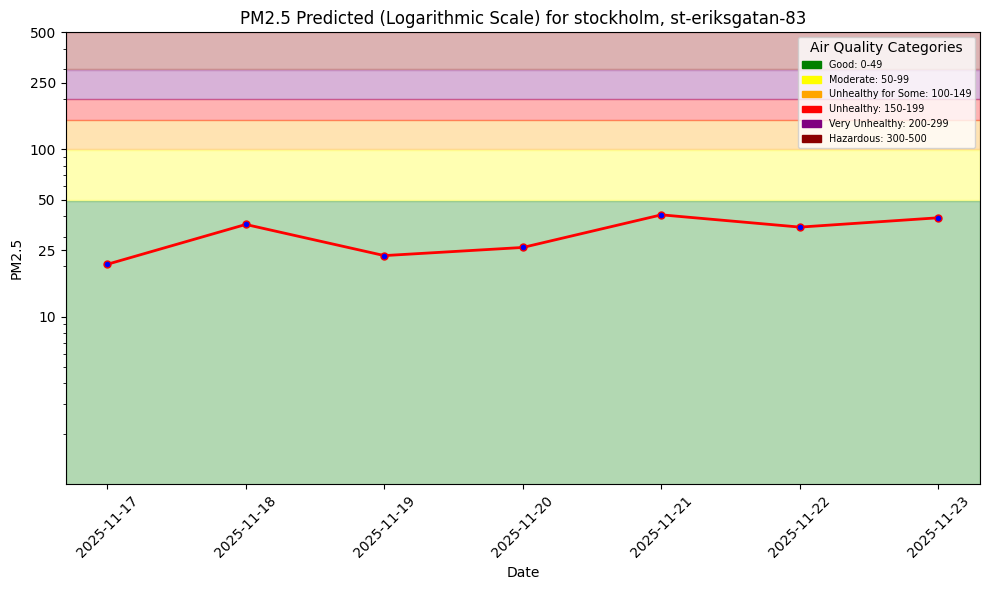

In [63]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [64]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_rolling',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [65]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286306/fs/1273933/fg/1721750


Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 7/7 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_rolling_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_rolling_1_offline_fg_materialization/executions
2025-11-16 15:50:16,192 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:50:19,385 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:52:04,384 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:52:04,547 INFO: Waiting for log aggregation to finish.
2025-11-16 15:52:13,172 INFO: Execution finished successfully.


(Job('aq_predictions_rolling_1_offline_fg_materialization', 'SPARK'), None)

In [66]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling1,rolling2,rolling3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,0.75,0.0,12.181624,325.84024,stockholm,7.0,9.5,10.666667,20.561321,st-eriksgatan-83,sweden,1


In [67]:
air_quality_fg = fs.get_feature_group(name='air_quality_rolling', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.06s) 


,date,pm25,rolling1,rolling2,rolling3,country,city,street,url
0,2024-04-06 00:00:00+00:00,14.0,16.0,14.0,13.000000,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
1,2020-06-16 00:00:00+00:00,25.0,18.0,16.0,15.666667,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
2,2019-01-28 00:00:00+00:00,44.0,45.0,44.0,51.000000,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
3,2019-02-21 00:00:00+00:00,36.0,39.0,50.0,49.666668,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
4,2021-10-27 00:00:00+00:00,12.0,35.0,29.5,25.333334,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
...,...,...,...,...,...,...,...,...,...
2457,2023-06-22 00:00:00+00:00,32.0,45.0,44.5,48.666668,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
2458,2025-11-13 00:00:00+00:00,9.0,18.0,19.5,18.000000,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
2459,2025-11-15 00:00:00+00:00,12.0,13.0,11.0,13.333333,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523
2460,2025-11-16 00:00:00+00:00,7.0,12.0,12.5,11.333333,sweden,stockholm,st-eriksgatan-83,https://api.waqi.info/feed/@10523


In [72]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring_predicted(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model,country,city,street,url)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 
2025-11-16 15:55:23,538 WARNING: UserWarning: Boolean Series key will be reindexed to match DataFrame index.



Uploading Dataframe: 100.00% |█████████████████████████████████| Rows 3/3 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_rolling_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_rolling_1_offline_fg_materialization/executions
2025-11-16 15:55:39,369 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 15:55:45,723 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 15:57:24,303 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 15:57:24,467 INFO: Waiting for log aggregation to finish.
2025-11-16 15:57:33,109 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling1,rolling2,rolling3,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,1.086083,0.0,16.800856,291.999786,stockholm,9.000000,13.500000,16.000000,25.327475,13.0,st-eriksgatan-83,sweden,1
1,2025-11-15 00:00:00+00:00,-0.036833,0.0,19.091883,269.060303,stockholm,25.327475,17.163738,17.163738,22.507587,12.0,st-eriksgatan-83,sweden,1
2,2025-11-16 00:00:00+00:00,2.650000,0.0,11.435313,241.821503,stockholm,22.507587,23.917530,23.917530,22.827929,7.0,st-eriksgatan-83,sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

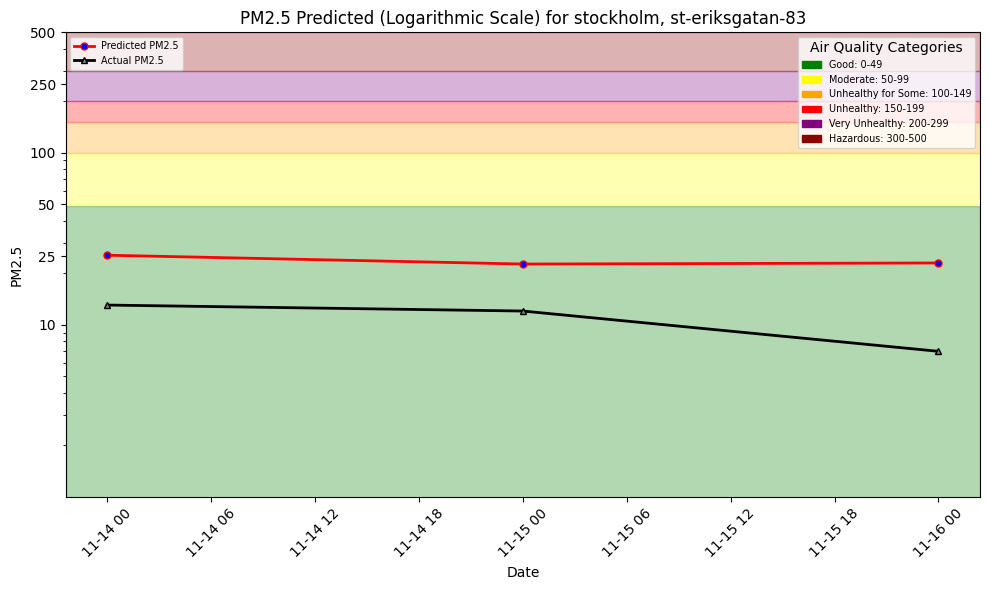

In [74]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [75]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.p…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286306/settings/fb/path/Resources/airquality


---